# Applying K-Nearest Neighbors (KNN) Regressor Algorithm 

This notebook explores the application of the K-Nearest Neighbors (KNN) Regressor algorithm to our data. We will use the KNN algorithm, play with its parameters and analyze its performance in making predictions based on our dataset.

Here, we will:

* Apply KNN to our data for regression and try different combinitions of it parameters.
* Evaluate the KNN model's performance using metrics Mean Squared Error, R-squared, and Mean Absolute Error
* Explore the impact of different parameters values on the model's performance.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler


In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [5]:
from sklearn.model_selection import cross_val_score

## Initial Modeling Approach: Raw Data

We will begin our exploration by applying the KNN algorithm directly to the original data, **without** any preprocessing steps. This initial approach will serve as a baseline for comparison as we investigate the potential benefits of data preprocessing techniques we applied.





In [6]:
df_original = pd.read_csv('data/data.csv')

df_original.drop("DateTime", inplace=True, axis=1)



In [7]:
df_original.rename(columns={
    "Zone 1 Power Consumption": "z1",
    "Zone 2  Power Consumption": "z2",
    "Zone 3  Power Consumption": "z3"
}, inplace=True)

In [8]:
df_z1_original = df_original.drop(["z2", "z3"], axis=1)
df_z2_original = df_original.drop(["z1", "z3"], axis=1)
df_z3_original = df_original.drop(["z1", "z2"], axis=1)

In [9]:
zones_original = [df_z1_original, df_z2_original, df_z3_original]
targets_original = ["z1", "z2", "z3"]

## Helper Functions

In [10]:
models_results = []

In [11]:
def evaluate_model(model, X_train, y_train, X_test, y_test, zone="Whole City"):
    # Predict on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for training data
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Calculate metrics for testing data
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Print the metrics
    print(f"Model: {model}")
    print("====== Train ========")
    print(f"Training MSE: {train_mse:.7f}")
    print(f"Training MAE: {train_mae:.7f}")
    print(f"Training R-squared: {train_r2:.7f}")
    print("====== Test ========")
    print(f"Testing MSE: {test_mse:.7f}")
    print(f"Testing MAE: {test_mae:.7f}")
    print(f"Testing R-squared: {test_r2:.7f}")
    
    new_row = {
        "Zone": zone,
        "Model": str(model),
        "Train MSE": train_mse,
        "Train MAE": train_mae,
        "Train R2": train_r2,
        "Test MSE": test_mse,
        "Test MAE": test_mae,
        "Test R2": test_r2
    }
    
  
    models_results.append(new_row)

In [12]:
def preprocess_data(df):
    # Melt the DataFrame to long format
    df_melted = df.melt(id_vars=['Zone', 'Model'], 
                        value_vars=['Train MSE', 'Train MAE', 'Train R2', 'Test MSE', 'Test MAE', 'Test R2'],
                        var_name='Metric', value_name='Value')

    # Split Metric into Data Type (Train/Test) and Actual Metric for easier plotting
    df_melted[['Data Type', 'Metric']] = df_melted['Metric'].str.split(' ', expand=True)
    
    return df_melted

In [13]:
def plot_results(df_melted):
   
    # Get unique metrics
    unique_metrics = df_melted['Metric'].unique()
    
    # Set the plot style
    sns.set(style="whitegrid")

    # Loop through each metric and create a separate plot
    for metric in unique_metrics:
        # Filter data for training and testing separately
        train_data = df_melted[(df_melted['Metric'] == metric) & (df_melted['Data Type'] == 'Train')]
        test_data = df_melted[(df_melted['Metric'] == metric) & (df_melted['Data Type'] == 'Test')]
        
        # Create separate plots for training and testing data
        for data, data_type in zip([train_data, test_data], ['Train', 'Test']):
            g = sns.catplot(
                data=data, kind="bar",
                x="Zone", y="Value", hue="Model",
                height=4, aspect=2, sharey=False
            )

            # Set plot titles and labels
            g.set_titles("{col_name} - " + metric)
            g.set_axis_labels(data_type + " " + str(metric), "Value")
            g.set_xticklabels(rotation=45)  
            
            # Adjust legend position and font size
            g._legend.set_bbox_to_anchor((1.1, 0.5))  
            g._legend.set_title('Model')  

            # Display the plot
            plt.tight_layout()
            plt.show()

In this part, we employed the KNN algorithm as our **base model** to evaluate its performance on the raw data. We analyzed metrics [r2_score, mean squared error, mean absolute error] to assess the model's effectiveness in making predictions.


## Evaluating KNN on Individual Zones

Now, we will see the performance of the KNN algorithm on each **zone** of our data **independently**. By isolating each zone, we can gain insights into:

* How the algorithm's effectiveness varies across different subsets of the data.
* Whether specific zones pose particular challenges for the KNN model.

We will apply the **base KNN model** (without any modifications) to each zone individually and analyze the resulting performance metrics. This will help us identify potential areas for improvement or optimization strategies tailored to specific zones.


In [14]:
for zone, target in zip(zones_original, targets_original):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    #fit the knn model
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)

    evaluate_model(knn, X_train, y_train, X_test, y_test, target)

 ---------------------- z1 ---------------------- 
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.3665647
Training MAE: 0.4012962
Training R-squared: 0.6334353
====== Test ========
Testing MSE: 0.5611122
Testing MAE: 0.5060919
Testing R-squared: 0.4340413
 ---------------------- z2 ---------------------- 
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.3776392
Training MAE: 0.4150653
Training R-squared: 0.6223608
====== Test ========
Testing MSE: 0.5764644
Testing MAE: 0.5208012
Testing R-squared: 0.4218060
 ---------------------- z3 ---------------------- 
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.2546336
Training MAE: 0.3366834
Training R-squared: 0.7453664
====== Test ========
Testing MSE: 0.3944382
Testing MAE: 0.4328279
Testing R-squared: 0.6027717


## Hyperparameter Tuning

Next, we'll use **grid search** to explore different combinations of KNN hyperparameters. This will help us identify the optimal configuration for our data that minimizes the MSE.

By finding the optimal hyperparameters, we aim to fine-tune the KNN model and improve its effectiveness. 


In [15]:
param_grid = {
    'n_neighbors': range(1, 11),  # Experiment with different k values
    'algorithm': ['auto', 'kd_tree'],  # Experiment with different algorithms 
    'metric': ['euclidean', 'manhattan', 'minkowski']  # Try different distance metrics
}


In [16]:
for zone, target in zip(zones_original, targets_original):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    # Create a kNN regressor with GridSearchCV for hyperparameter tuning
    knn_reg = KNeighborsRegressor()
    grid_search = GridSearchCV(knn_reg, param_grid, scoring='neg_mean_squared_error')  # Minimize MSE

    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    print(f"Best model: {best_model}")
    
    evaluate_model(best_model, X_train, y_train, X_test, y_test, target)                  

 ---------------------- z1 ---------------------- 
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
====== Train ========
Training MSE: 0.3970462
Training MAE: 0.4302117
Training R-squared: 0.6029538
====== Test ========
Testing MSE: 0.5386048
Testing MAE: 0.5060854
Testing R-squared: 0.4567432
 ---------------------- z2 ---------------------- 
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
====== Train ========
Training MSE: 0.4096149
Training MAE: 0.4442301
Training R-squared: 0.5903851
====== Test ========
Testing MSE: 0.5524593
Testing MAE: 0.5195120
Testing R-squared: 0.4458831
 ---------------------- z3 ---------------------- 
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=7)
====== Train ========
Training MSE: 0.2772832
Training MAE: 0.362644

## Cross-Validation 

We'll use **cross-validation** to estimate the KNN model's performance on unseen data and avoid overfitting. This involves splitting the data into folds, training on some folds and testing on others, and averaging the results across all folds. This provides a more reliable measure of the model's generalizability.


=================== z1 ==================
Best MSE is 0.5650684219385969
Best K is 8


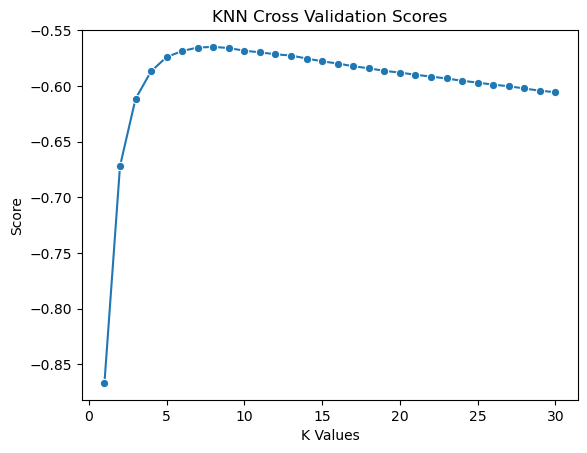

=================== z2 ==================
Best MSE is 0.5883071700913126
Best K is 8


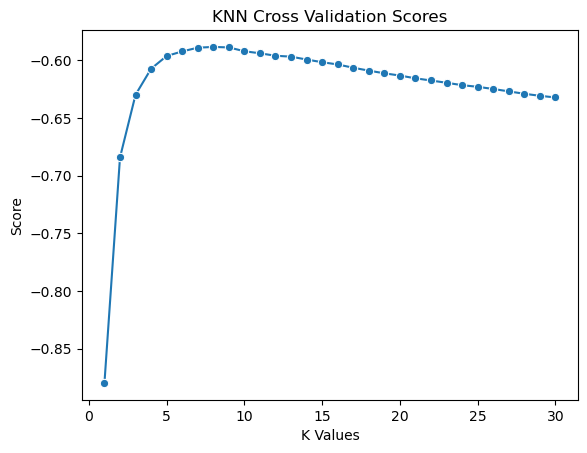

=================== z3 ==================
Best MSE is 0.4027133766316043
Best K is 7


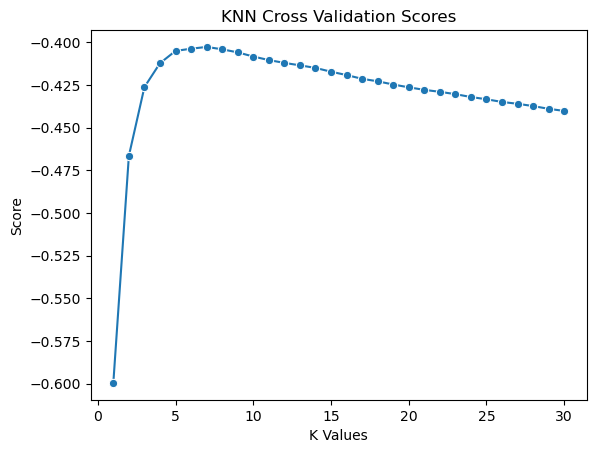

In [17]:
for zone, target in zip(zones_original, targets_original):
    print(f"=================== {target} ==================")
    X = zone.drop(target, axis=1)
    y = zone[target]

    k_values = [i for i in range(1, 31)]
    scores = []
    best_score = -float('inf')
    best_k = None

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        score = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error') )
        scores.append(score)
        if score > best_score:
            best_score = score
            best_k = k

    sns.lineplot(x=k_values, y=scores, marker='o')
    
    print(f"Best MSE is {-best_score}")
    print(f"Best K is {best_k}")

    plt.xlabel(f"K Values")
    plt.ylabel("Score")
    plt.title("KNN Cross Validation Scores")
    plt.show()

## Evaluating KNN on the Entire City

Let's shift our focus to the **entire city** data. We will now apply the KNN algorithm, incorporating the learnings from hyperparameter tuning after summing the consumption of all the zones of the city. 


By analyzing the KNN model's behavior on the entire city data, we can gain a broader understanding of its suitability for our application in this context.


In [18]:
df_original["city_consumption"] = df_z1_original["z1"] + df_z2_original["z2"] + df_z3_original["z3"]
df_original.drop(["z1", "z2", "z3"], axis=1,inplace=True)
df_original

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,city_consumption
0,6.559,73.8,0.083,0.051,0.119,70425.53544
1,6.414,74.5,0.083,0.070,0.085,69320.84387
2,6.313,74.5,0.080,0.062,0.100,67803.22193
3,6.121,75.0,0.083,0.091,0.096,65489.23209
4,5.921,75.7,0.081,0.048,0.085,63650.44627
...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,72798.08659
52412,6.947,72.6,0.082,0.051,0.093,70983.80786
52413,6.900,72.8,0.086,0.084,0.074,68675.04965
52414,6.758,73.0,0.080,0.066,0.089,67163.01682


In [19]:
target = "city_consumption"

In [20]:
print(f" ---------------------- Whole city ---------------------- ")
X = df_original.drop(target, axis=1)
y = df_original[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

#fit the knn model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
evaluate_model(knn, X_train, y_train, X_test, y_test)                   

 ---------------------- Whole city ---------------------- 
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.3216367
Training MAE: 0.3743083
Training R-squared: 0.6783633
====== Test ========
Testing MSE: 0.4894106
Testing MAE: 0.4732186
Testing R-squared: 0.5059667


In [21]:
print(f" ---------------------- Whole city ---------------------- ")
X = df_original.drop(target, axis=1)
y = df_original[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Create a kNN regressor with GridSearchCV for hyperparameter tuning
knn_reg = KNeighborsRegressor()
grid_search = GridSearchCV(knn_reg, param_grid, scoring='neg_mean_squared_error')  # Minimize MSE

grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

evaluate_model(best_model, X_train, y_train, X_test, y_test)

 ---------------------- Whole city ---------------------- 
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=6)
====== Train ========
Training MSE: 0.3330511
Training MAE: 0.3868114
Training R-squared: 0.6669489
====== Test ========
Testing MSE: 0.4731421
Testing MAE: 0.4691189
Testing R-squared: 0.5223889


 ---------------------- Whole city ---------------------- 
Best MSE is -0.5014932113490991
Best K is 8


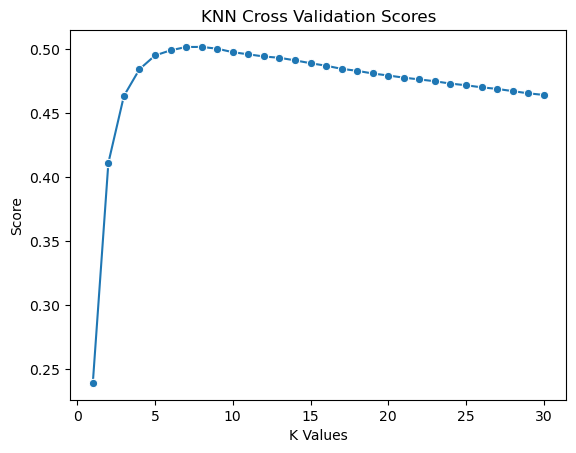

In [22]:

print(f" ---------------------- Whole city ---------------------- ")
X = df_original.drop(target, axis=1)
y = df_original[target]

k_values = [i for i in range(1, 31)]
scores = []
best_score = -float('inf')
best_k = None

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    score = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='r2'))
    scores.append(score)
    if score > best_score:
        best_score = score
        best_k = k

sns.lineplot(x=k_values, y=scores, marker='o')

print(f"Best MSE is {-best_score}")
print(f"Best K is {best_k}")

plt.xlabel(f"K Values")
plt.ylabel("Score")
plt.title("KNN Cross Validation Scores")
plt.show()

In [23]:
models_results

[{'Zone': 'z1',
  'Model': 'KNeighborsRegressor()',
  'Train MSE': 0.36656469254220636,
  'Train MAE': 0.40129617082194813,
  'Train R2': 0.6334353074577936,
  'Test MSE': 0.5611122346099089,
  'Test MAE': 0.5060918582311908,
  'Test R2': 0.4340413310428214},
 {'Zone': 'z2',
  'Model': 'KNeighborsRegressor()',
  'Train MSE': 0.37763922579799886,
  'Train MAE': 0.4150652917275521,
  'Train R2': 0.622360774202001,
  'Test MSE': 0.5764644292176823,
  'Test MAE': 0.5208011887465879,
  'Test R2': 0.4218059865684186},
 {'Zone': 'z3',
  'Model': 'KNeighborsRegressor()',
  'Train MSE': 0.25463363220301427,
  'Train MAE': 0.3366833505471478,
  'Train R2': 0.7453663677969857,
  'Test MSE': 0.39443822586743565,
  'Test MAE': 0.43282788660812993,
  'Test R2': 0.6027716937615772},
 {'Zone': 'z1',
  'Model': "KNeighborsRegressor(metric='manhattan', n_neighbors=7)",
  'Train MSE': 0.3970462068595061,
  'Train MAE': 0.4302117400187825,
  'Train R2': 0.602953793140494,
  'Test MSE': 0.5386047959643964,

In [24]:
results = pd.DataFrame(models_results)
results 

,Zone,Model,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,z1,KNeighborsRegressor(),0.366565,0.401296,0.633435,0.561112,0.506092,0.434041
1,z2,KNeighborsRegressor(),0.377639,0.415065,0.622361,0.576464,0.520801,0.421806
2,z3,KNeighborsRegressor(),0.254634,0.336683,0.745366,0.394438,0.432828,0.602772
3,z1,"KNeighborsRegressor(metric='manhattan', n_neig...",0.397046,0.430212,0.602954,0.538605,0.506085,0.456743
4,z2,"KNeighborsRegressor(metric='manhattan', n_neig...",0.409615,0.444230,0.590385,0.552459,0.519512,0.445883
5,z3,"KNeighborsRegressor(metric='manhattan', n_neig...",0.277283,0.362645,0.722717,0.382125,0.433901,0.615172
6,Whole City,KNeighborsRegressor(),0.321637,0.374308,0.678363,0.489411,0.473219,0.505967
7,Whole City,"KNeighborsRegressor(metric='manhattan', n_neig...",0.333051,0.386811,0.666949,0.473142,0.469119,0.522389


/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


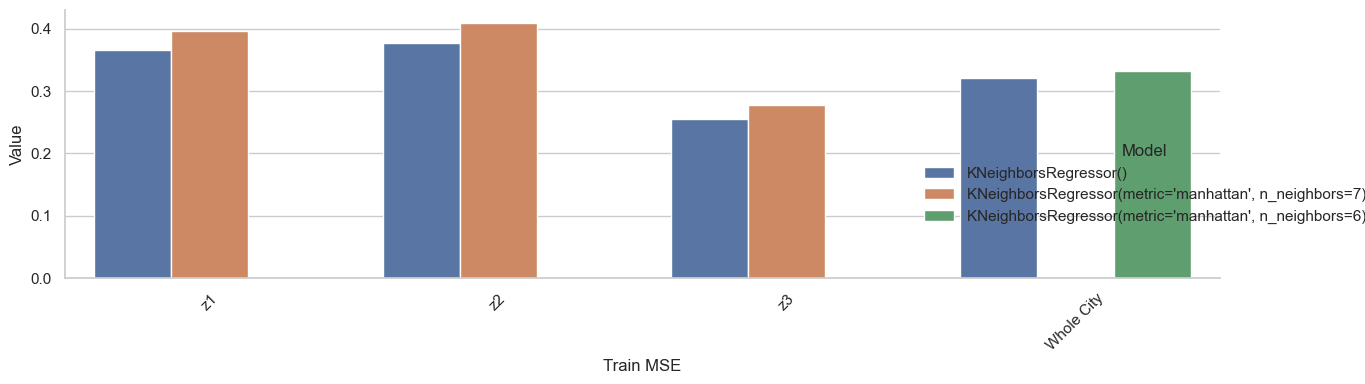

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


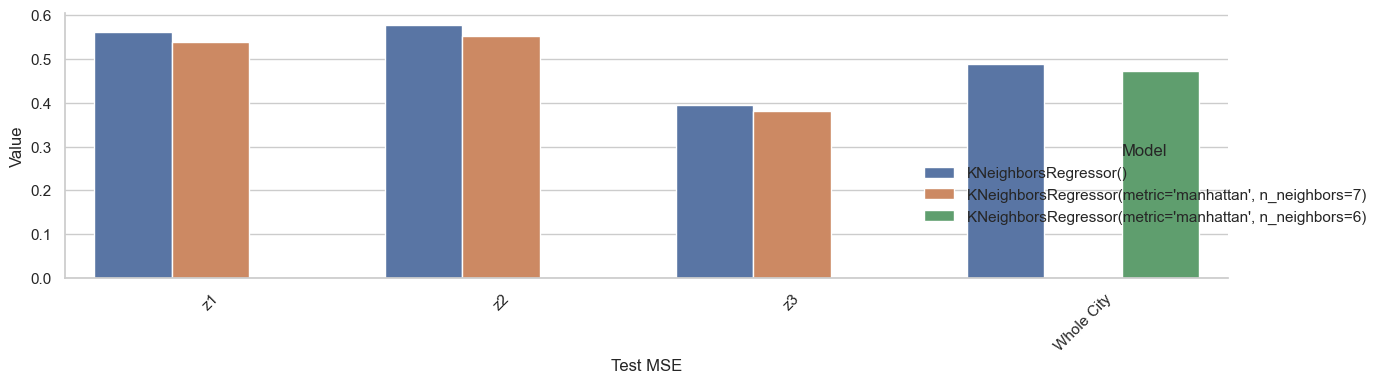

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


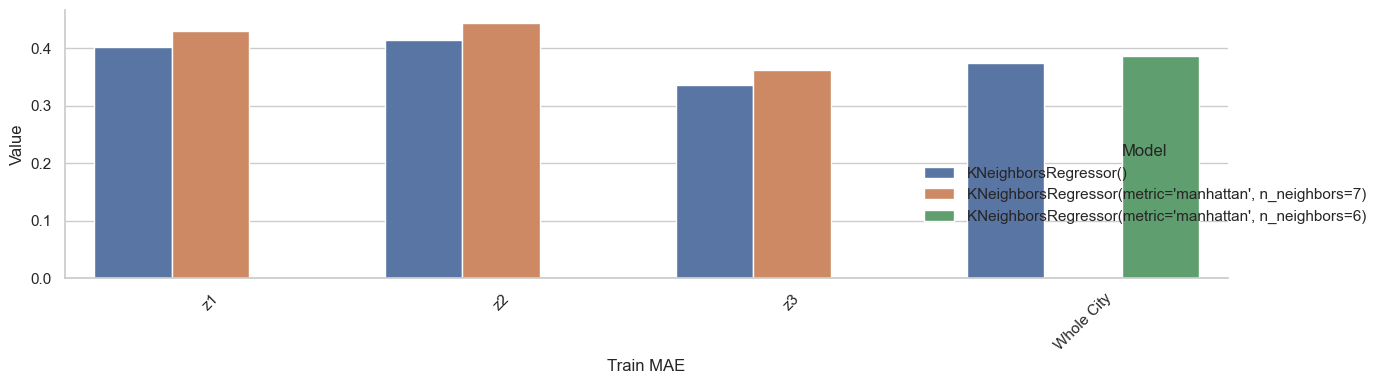

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


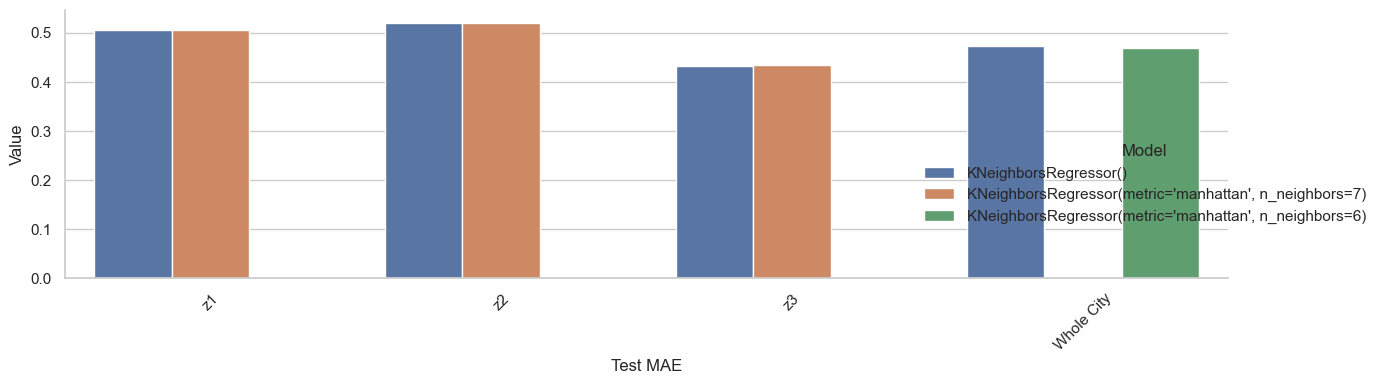

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


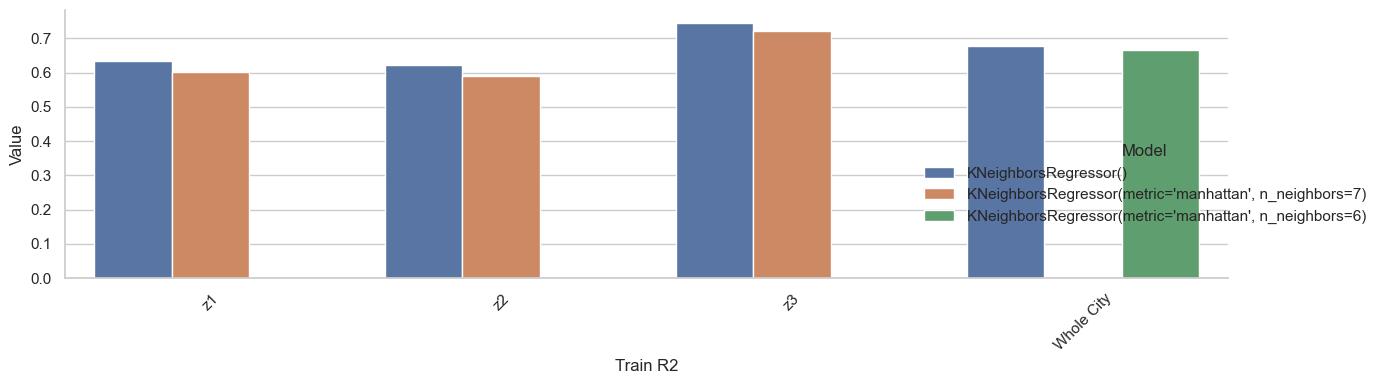

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


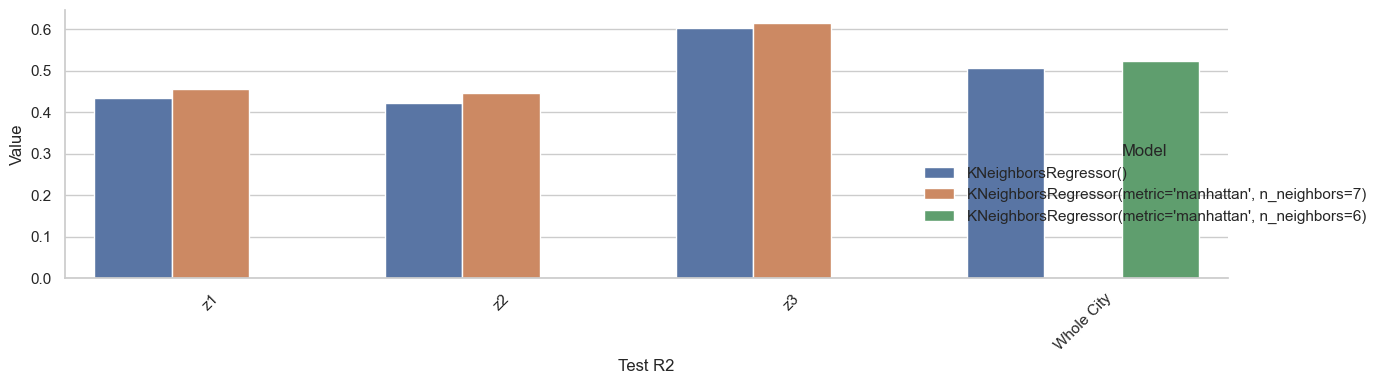

In [25]:
df_melted = preprocess_data(results)

# Plot the results
plot_results(df_melted)

## KNN Performance on Individual Cities vs. Entire City on Original Data

Our analysis of individual cities revealed that the best KNN configuration was `KNeighborsRegressor(metric='manhattan', n_neighbors=7)`. However, when applied to the entire city dataset, the optimal configuration shifted to `KNeighborsRegressor(metric='manhattan', n_neighbors=6)`.

Despite these adjustments, the overall results remain unsatisfactory. The model does not performs well on the training data, nor the test data suggesting it still struggling to learn the patterns within that data. 

To address this issue and potentially improve the model's generalizability, we will explore the impact of data preprocessing techniques in the next section. By cleaning and transforming the data, we aim to create a more robust dataset that the KNN model can effectively learn from and achieve better results on unseen data across individual cities and the entire city as a whole.


# -----------------------------------------------------------

# Analyzing Preprocessed Data: Exploring Improvements

Having identified limitations in the KNN model's performance on the raw data, let's now turn our attention to **preprocessed data**. We will apply the same KNN algorithm and hyperparameter tuning techniques to the preprocessed dataset and compare the results.

By analyzing the KNN model's performance on preprocessed data, we aim to:

* Assess the impact of data preprocessing on the model's effectiveness.
* Determine if preprocessing techniques mitigate overfitting and improve generalizability.
* Explore whether the optimal hyperparameters for the KNN model differ based on the data quality.

By comparing the results obtained from the raw and preprocessed data, we can gain valuable insights into the effectiveness of data preprocessing in our specific scenario.


In [26]:
models_results = []

In [27]:
df = pd.read_csv("data/data-ready.csv")
df

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,z1,z2,z3,Year,...,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299


In [28]:
df.describe()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,z1,z2,z3,Year,Month,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin
count,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,52416.0,52416.000000,52416.000000,52416.000000,52416.000000,52416.000000,5.241600e+04,5.241600e+04,5.241600e+04,5.241600e+04,52416.000000,5.241600e+04
mean,18.810024,68.259518,1.959489,182.696614,75.028022,32344.970564,21042.509082,17835.406218,2017.0,6.510989,15.678571,11.500000,0.285714,0.458333,-6.940588e-17,-1.918151e-17,-5.126443e-03,-5.395884e-03,-0.021699,1.636413e-03
std,5.815476,15.551177,2.348862,264.400960,124.210949,7130.562564,5201.465892,6622.165099,0.0,3.440642,8.771822,6.922253,0.451758,0.498266,7.071135e-01,7.071135e-01,7.075804e-01,7.066071e-01,0.699348,7.144631e-01
min,3.247000,11.340000,0.050000,0.004000,0.011000,13895.696200,8560.081466,5935.174070,2017.0,1.000000,1.000000,0.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-0.994869,-9.987165e-01
25%,14.410000,58.310000,0.078000,0.062000,0.122000,26310.668692,16980.766032,13129.326630,2017.0,4.000000,8.000000,5.750000,0.000000,0.000000,-7.071068e-01,-7.071068e-01,-8.660254e-01,-8.660254e-01,-0.758758,-7.247928e-01
50%,18.780000,69.860000,0.086000,5.035500,4.456000,32265.920340,20823.168405,16415.117470,2017.0,7.000000,16.000000,11.500000,0.000000,0.000000,-6.123234e-17,6.123234e-17,-1.836970e-16,-2.449294e-16,-0.050649,-2.449294e-16
75%,22.890000,81.400000,4.915000,319.600000,101.000000,37309.018185,24713.717520,21624.100420,2017.0,9.250000,23.000000,17.250000,1.000000,1.000000,7.071068e-01,7.071068e-01,5.915064e-01,5.000000e-01,0.688967,7.247928e-01
max,40.010000,94.800000,6.483000,1163.000000,936.000000,52204.395120,37408.860760,47598.326360,2017.0,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,9.987165e-01


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DateTime               52416 non-null  object 
 1   Temperature            52416 non-null  float64
 2   Humidity               52416 non-null  float64
 3   Wind Speed             52416 non-null  float64
 4   general diffuse flows  52416 non-null  float64
 5   diffuse flows          52416 non-null  float64
 6   z1                     52416 non-null  float64
 7   z2                     52416 non-null  float64
 8   z3                     52416 non-null  float64
 9   Year                   52416 non-null  int64  
 10  Month                  52416 non-null  int64  
 11  Day                    52416 non-null  int64  
 12  Hour                   52416 non-null  int64  
 13  IsWeekend              52416 non-null  int64  
 14  IsNight                52416 non-null  int64  
 15  Ho

In [30]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df

,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,z1,z2,z3,Year,...,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,2017,...,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52412,2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52413,2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299
52414,2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,2017,...,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299


In [31]:
df = df.drop("DateTime", axis=1)

In [32]:
df.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'z1', 'z2', 'z3', 'Year', 'Month', 'Day', 'Hour',
       'IsWeekend', 'IsNight', 'HourCos', 'HourSin', 'MonthCos', 'MonthSin',
       'DayCos', 'DaySin'],
      dtype='object')

In [33]:
df_z1 = df.drop(["z2", "z3"], axis=1)
df_z2 = df.drop(["z1", "z3"], axis=1)
df_z3 = df.drop(["z1", "z2"], axis=1)

## Preprocessed Data: Zone-by-Zone Analysis

We'll now analyze each zone using the KNN model with hyperparameter tuning and preprocessed data. This will help us:

* Assess preprocessing's impact on zone-level performance.
* Identify zone-specific challenges or areas for optimization.

By comparing raw vs. preprocessed results, we can gain insights into:

* Preprocessing effectiveness for different zones.
* Zone-specific variations in optimal KNN configuration.
* Overall model improvement due to preprocessing.

This analysis will inform potential zone-specific optimizations or alternative approaches.


In [34]:
zones = [df_z1, df_z2, df_z3]
targets = ["z1", "z2", "z3"]

## Evaluating Base KNN Model on Preprocessed Data

Having explored data preprocessing techniques, let's now evaluate the impact on the KNN model's performance. We'll begin by applying the **base KNN model** (without modifications) to the preprocessed data.

By analyzing the performance of the base KNN model on preprocessed data, we can gain insights into the effectiveness of data preprocessing in our specific scenario. In the next steps, we can further explore hyperparameter tuning to potentially refine the KNN model's performance on the preprocessed data.


In [35]:
for zone, target in zip(zones, targets):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    #fit the knn model
    knn = KNeighborsRegressor()
    knn.fit(X_train, y_train)

    evaluate_model(knn, X_train, y_train, X_test, y_test, target)          

 ---------------------- z1 ---------------------- 
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.0136693
Training MAE: 0.0757178
Training R-squared: 0.9863307
====== Test ========
Testing MSE: 0.0232145
Testing MAE: 0.0998687
Testing R-squared: 0.9765850
 ---------------------- z2 ---------------------- 
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.0119084
Training MAE: 0.0709736
Training R-squared: 0.9880916
====== Test ========
Testing MSE: 0.0209231
Testing MAE: 0.0960778
Testing R-squared: 0.9790141
 ---------------------- z3 ---------------------- 
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.0070173
Training MAE: 0.0505268
Training R-squared: 0.9929827
====== Test ========
Testing MSE: 0.0120098
Testing MAE: 0.0676709
Testing R-squared: 0.9879052


## Hyperparameter Tuning with Grid Search on Preprocessed Data

After establishing the baseline performance with the base KNN model on preprocessed data, let us explore hyperparameter tuning. Here, we will leverage **grid search** to systematically explore different combinations of hyperparameter values for the KNN model on the preprocessed dataset.

The preprocessed data may exhibit different characteristics compared to the raw data, potentially influencing the optimal hyperparameter settings for the KNN model. Grid search allows us to efficiently evaluate various configurations and identify the one that yields the best performance on the preprocessed data.


In [36]:
for zone, target in zip(zones, targets):
    print(f" ---------------------- {target} ---------------------- ")
    X = zone.drop(target, axis=1)
    y = zone[target]

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()
    
    # Create a kNN regressor with GridSearchCV for hyperparameter tuning
    knn_reg = KNeighborsRegressor()
    grid_search = GridSearchCV(knn_reg, param_grid, scoring='neg_mean_squared_error')  # Minimize MSE

    grid_search.fit(X_train, y_train)

    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    print(f"Best model: {best_model}")
    
    evaluate_model(best_model, X_train, y_train, X_test, y_test, target)
                            

 ---------------------- z1 ---------------------- 
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
====== Train ========
Training MSE: 0.0000000
Training MAE: 0.0000000
Training R-squared: 1.0000000
====== Test ========
Testing MSE: 0.0154539
Testing MAE: 0.0794098
Testing R-squared: 0.9844127
 ---------------------- z2 ---------------------- 
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
====== Train ========
Training MSE: 0.0000000
Training MAE: 0.0000000
Training R-squared: 1.0000000
====== Test ========
Testing MSE: 0.0133496
Testing MAE: 0.0735949
Testing R-squared: 0.9866103
 ---------------------- z3 ---------------------- 
Best model: KNeighborsRegressor(metric='manhattan', n_neighbors=2)
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=2)
====== Train ========
Training MSE: 0.0020614
Training MAE: 0.026815

## Cross-Validation on Preprocessed Data for Robustness

Having identified the optimal hyperparameters for the KNN model on the preprocessed data, let's now assess its generalizability using **cross-validation**.

By performing cross-validation on the preprocessed data, we can gain confidence in the KNN model's ability to perform well on new, unseen data, considering the potential benefits of data preprocessing in reducing overfitting and improving generalizability.


=================== z1 ==================
Best MSE is 0.021195839477609012
Best K is 1


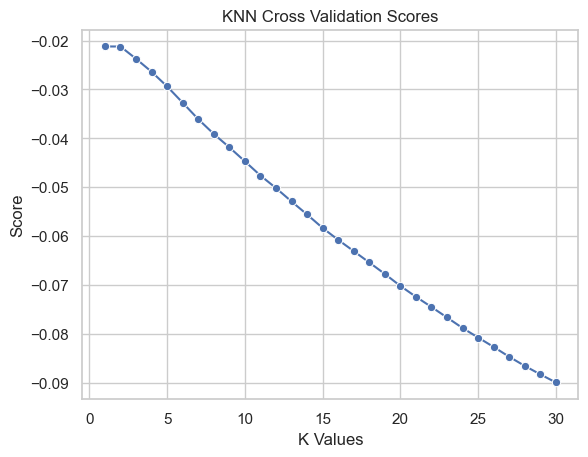

=================== z2 ==================
Best MSE is 0.01798171076934356
Best K is 1


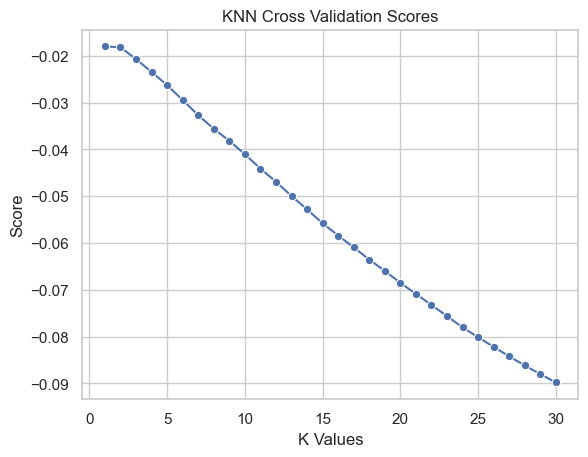

=================== z3 ==================
Best MSE is 0.010754577574828398
Best K is 2


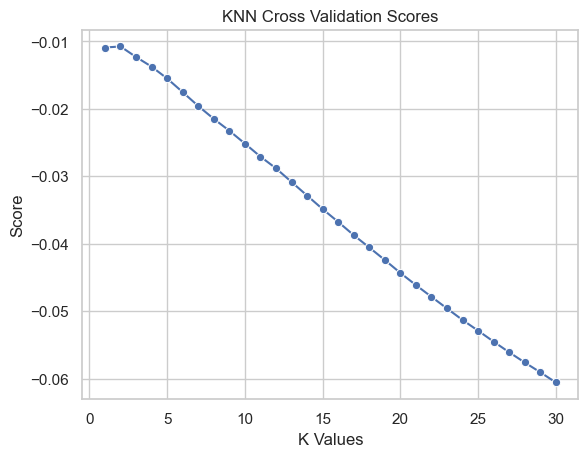

In [37]:
for zone, target in zip(zones, targets):
    print(f"=================== {target} ==================")
    X = zone.drop(target, axis=1)
    y = zone[target]

    k_values = [i for i in range(1, 31)]
    scores = []
    best_score = -float('inf')
    best_k = None

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features using StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    target_scaler = StandardScaler()
    y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


    for k in k_values:
        knn = KNeighborsRegressor(n_neighbors=k)
        score = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error') )
        scores.append(score)
        if score > best_score:
            best_score = score
            best_k = k

    sns.lineplot(x=k_values, y=scores, marker='o')
    
    print(f"Best MSE is {-best_score}")
    print(f"Best K is {best_k}")

    plt.xlabel(f"K Values")
    plt.ylabel("Score")
    plt.title("KNN Cross Validation Scores")
    plt.show()

## Evaluating KNN on the Entire City - Preprocessed Data -

Now that we've explored data preprocessing, let's re-evaluate the KNN model's performance on the **entire city** using the preprocessed data. 

In [38]:
df["city_consumption"] = df_z1["z1"] + df_z2["z2"] + df_z3["z3"]
df.drop(["z1", "z2", "z3"], axis=1,inplace=True)
df

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Year,Month,Day,Hour,IsWeekend,IsNight,HourCos,HourSin,MonthCos,MonthSin,DayCos,DaySin,city_consumption
0,6.559,73.8,0.083,0.051,0.119,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,70425.53544
1,6.414,74.5,0.083,0.070,0.085,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,69320.84387
2,6.313,74.5,0.080,0.062,0.100,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,67803.22193
3,6.121,75.0,0.083,0.091,0.096,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,65489.23209
4,5.921,75.7,0.081,0.048,0.085,2017,1,1,0,1,1,1.000000,0.000000,0.866025,5.000000e-01,0.97953,0.201299,63650.44627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,7.010,72.4,0.080,0.040,0.096,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,72798.08659
52412,6.947,72.6,0.082,0.051,0.093,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,70983.80786
52413,6.900,72.8,0.086,0.084,0.074,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,68675.04965
52414,6.758,73.0,0.080,0.066,0.089,2017,12,30,23,1,1,0.965926,-0.258819,1.000000,-2.449294e-16,0.97953,-0.201299,67163.01682


In [39]:
target = "city_consumption"

## Evaluating Base KNN Model on Preprocessed City Data

Following our exploration of data preprocessing techniques, let's now evaluate their impact on the KNN model's performance for the **entire city**. We'll begin by applying the **base KNN model** (without modifications) to the preprocessed city-wide data.


In [40]:
print(f" ---------------------- Whole city ---------------------- ")
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

#fit the knn model
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
evaluate_model(knn, X_train, y_train, X_test, y_test)     

 ---------------------- Whole city ---------------------- 
Model: KNeighborsRegressor()
====== Train ========
Training MSE: 0.0107005
Training MAE: 0.0657483
Training R-squared: 0.9892995
====== Test ========
Testing MSE: 0.0181450
Testing MAE: 0.0868991
Testing R-squared: 0.9816836


## Grid Search

In this step, we will delve deeper by applying **grid search** to explore different combinations of hyperparameter values for the KNN model on the preprocessed city-wide data.



In [41]:
print(f" ---------------------- Whole city ---------------------- ")
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Create a kNN regressor with GridSearchCV for hyperparameter tuning
knn_reg = KNeighborsRegressor()
grid_search = GridSearchCV(knn_reg, param_grid, scoring='neg_mean_squared_error')  # Minimize MSE

grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

evaluate_model(best_model, X_train, y_train, X_test, y_test)

 ---------------------- Whole city ---------------------- 
Model: KNeighborsRegressor(metric='manhattan', n_neighbors=1)
====== Train ========
Training MSE: 0.0000000
Training MAE: 0.0000000
Training R-squared: 1.0000000
====== Test ========
Testing MSE: 0.0126354
Testing MAE: 0.0702818
Testing R-squared: 0.9872453


By performing grid search, we aim to fine-tune the KNN model on the preprocessed city data and potentially unlock its full potential in this improved data environment.

After identifying the optimal hyperparameters, we'll leverage **cross-validation** to assess the generalizability of the tuned KNN model on the preprocessed city-wide data. 


 ---------------------- Whole city ---------------------- 
Best MSE is -0.9836684989087395
Best K is 2


<function matplotlib.pyplot.show(close=None, block=None)>

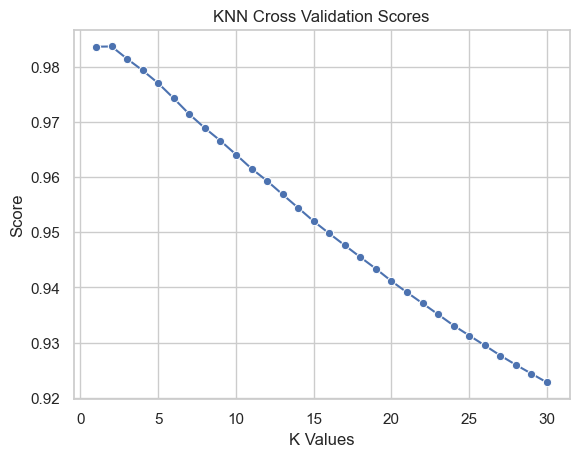

In [42]:
print(f" ---------------------- Whole city ---------------------- ")
X = df.drop(target, axis=1)
y = df[target]

k_values = [i for i in range(1, 31)]
scores = []
best_score = -float('inf')
best_k = None

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()


for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    score = np.mean(cross_val_score(knn, X_train, y_train, cv=5, scoring='r2'))
    scores.append(score)
    if score > best_score:
        best_score = score
        best_k = k

sns.lineplot(x=k_values, y=scores, marker='o')

print(f"Best MSE is {-best_score}")
print(f"Best K is {best_k}")

plt.xlabel(f"K Values")
plt.ylabel("Score")
plt.title("KNN Cross Validation Scores")
plt.show

## Visualization of KNN Model Performance

To gain a deeper understanding of the KNN model's behavior under different conditions, we will create visualizations that compare its performance metrics across various scenarios. Here, we will focus on:

* **Mean Squared Error (MSE):** Measures the average squared difference between predicted and actual values. Lower MSE indicates better performance.
* **R-squared (R²):** Represents the proportion of variance in the target variable explained by the model. Higher R² suggests better model fit.
* **Absolute Squared Error (ASE):** Similar to MSE, but without squaring the errors. Can be useful for interpreting individual errors.

We will present these metrics for both the training and test data sets, allowing us to assess:

* **Model Fit:** Performance on the training data indicates how well the model learns the patterns within that data.
* **Generalizability:** Performance on the test data reflects how well the model performs on unseen data. Ideally, the metrics should be similar for both training and test data.



In [43]:
results = pd.DataFrame(models_results)
results 

,Zone,Model,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,z1,KNeighborsRegressor(),0.013669,0.075718,0.986331,0.023214,0.099869,0.976585
1,z2,KNeighborsRegressor(),0.011908,0.070974,0.988092,0.020923,0.096078,0.979014
2,z3,KNeighborsRegressor(),0.007017,0.050527,0.992983,0.012010,0.067671,0.987905
3,z1,"KNeighborsRegressor(metric='manhattan', n_neig...",0.000000,0.000000,1.000000,0.015454,0.079410,0.984413
4,z2,"KNeighborsRegressor(metric='manhattan', n_neig...",0.000000,0.000000,1.000000,0.013350,0.073595,0.986610
5,z3,"KNeighborsRegressor(metric='manhattan', n_neig...",0.002061,0.026816,0.997939,0.007430,0.049617,0.992518
6,Whole City,KNeighborsRegressor(),0.010700,0.065748,0.989300,0.018145,0.086899,0.981684
7,Whole City,"KNeighborsRegressor(metric='manhattan', n_neig...",0.000000,0.000000,1.000000,0.012635,0.070282,0.987245


In [55]:
results["Model"].unique()

array(['KNeighborsRegressor()',
       "KNeighborsRegressor(metric='manhattan', n_neighbors=1)",
       "KNeighborsRegressor(metric='manhattan', n_neighbors=2)"],
      dtype=object)

In [63]:
results[results["Zone"]=="Whole City"]["Model"].unique()

array(['KNeighborsRegressor()',
       "KNeighborsRegressor(metric='manhattan', n_neighbors=1)"],
      dtype=object)

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


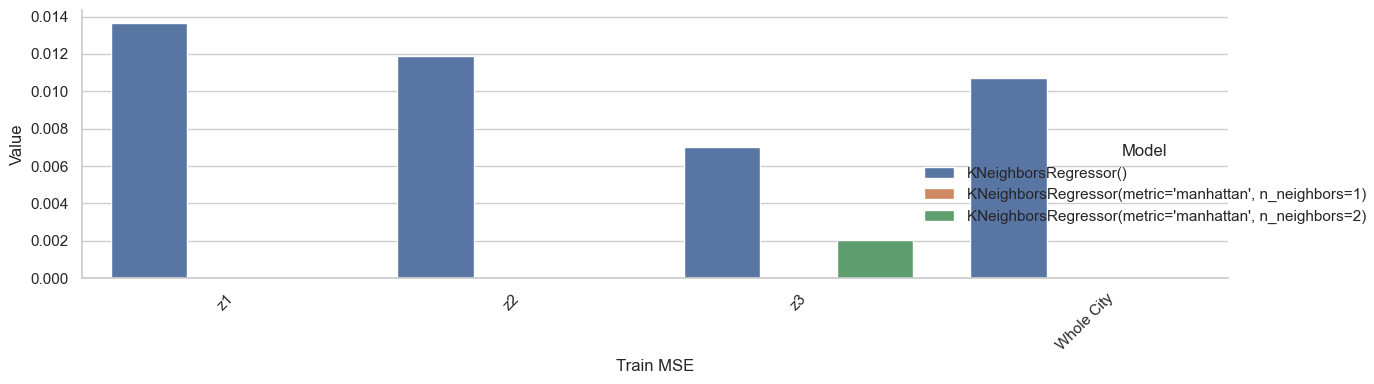

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


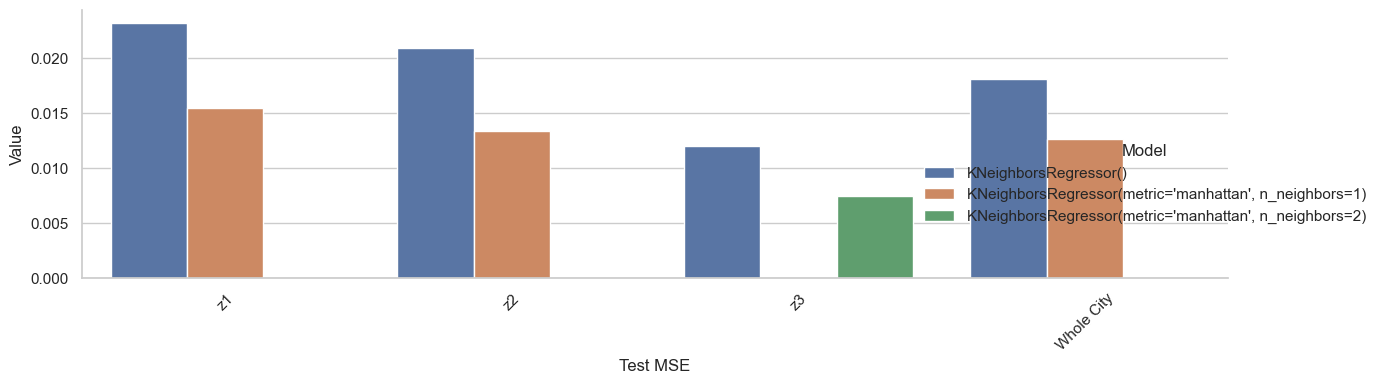

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


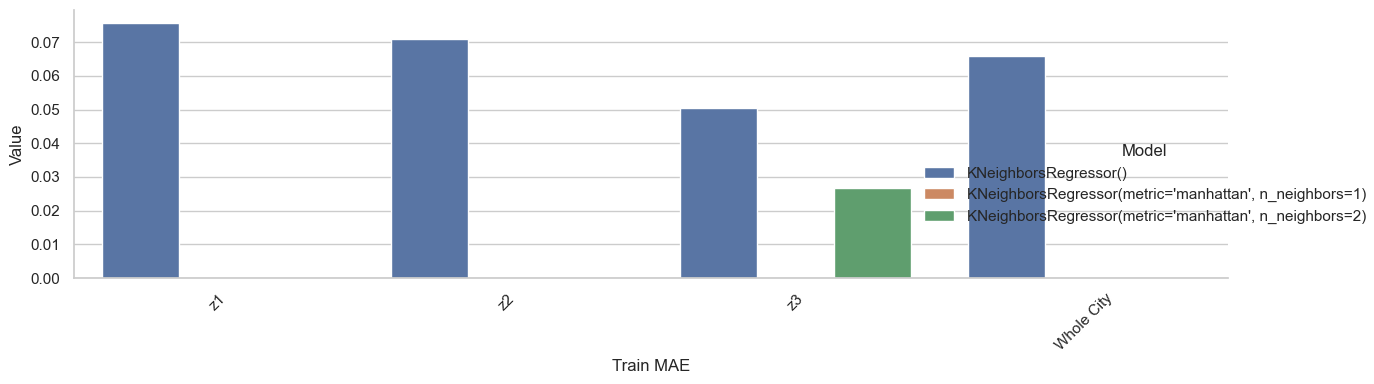

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


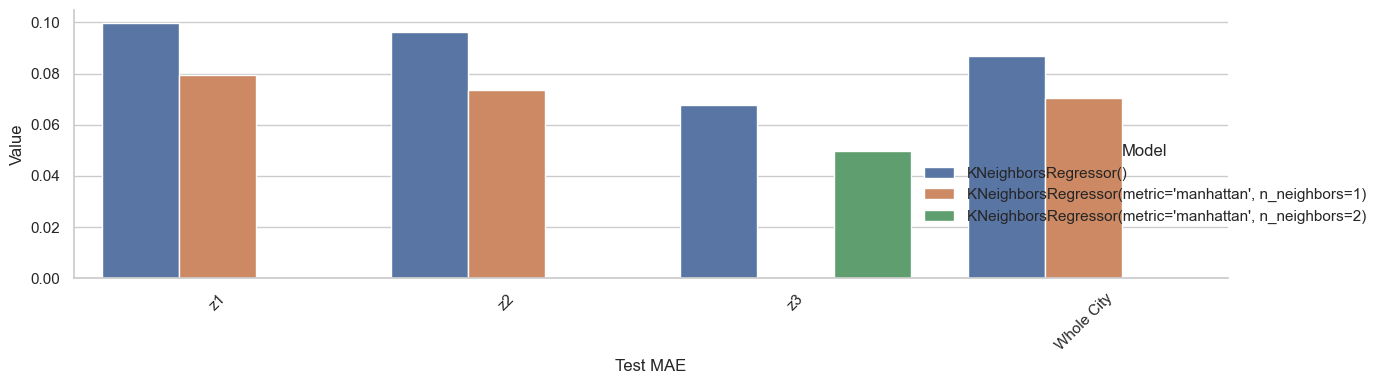

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


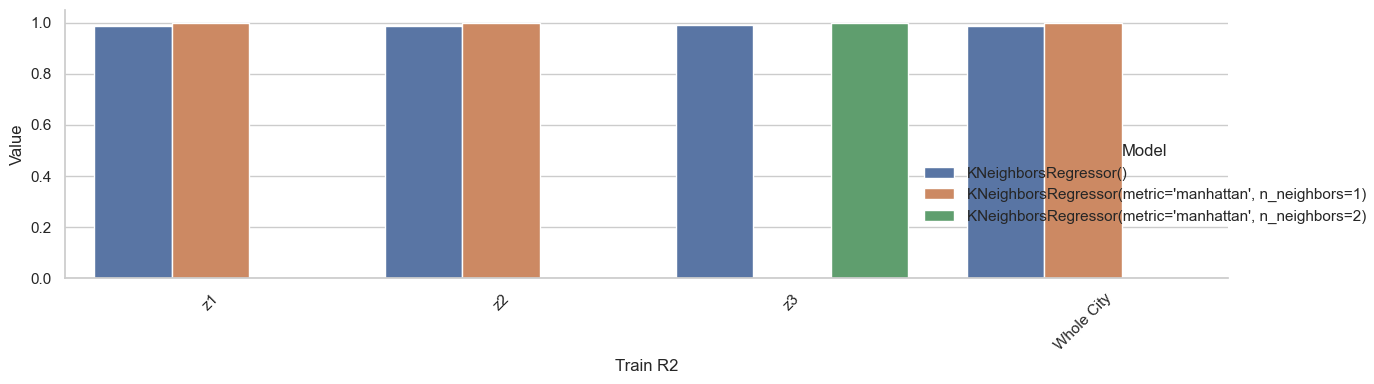

/Users/abdelhak/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/ss/0swg8ybn4677sffp8j5pd_kw0000gn/T/ipykernel_24592/248893769.py:33: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


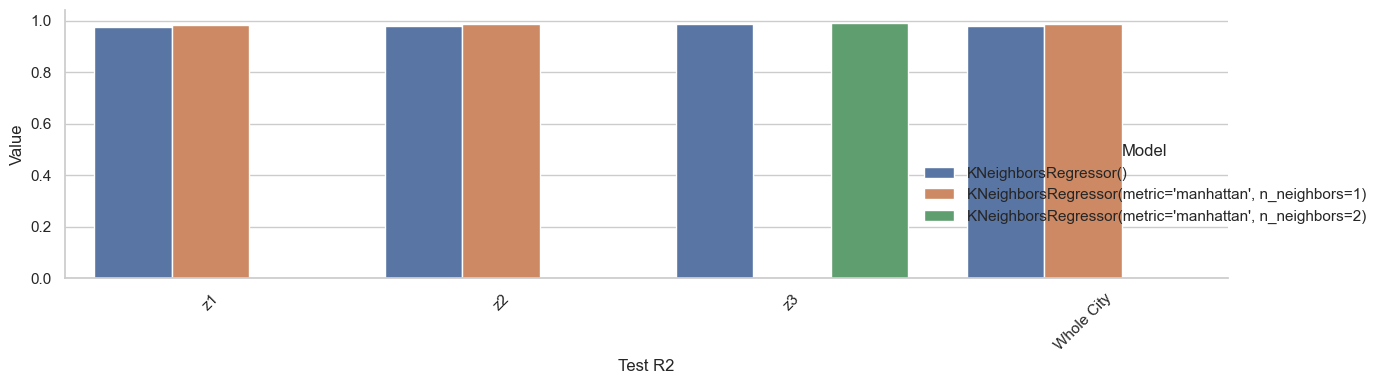

In [44]:
df_melted = preprocess_data(results)

# Plot the results
plot_results(df_melted)

## Zone-Level and City-Wide KNN Model Performance with Preprocessed Data

Our analysis of KNN models on the preprocessed data revealed zone-specific optimal configurations and significant improvements compared to the raw data:

* **Zones 1 & 2:** The best performing model for Zones 1 and 2 was `KNeighborsRegressor(metric='manhattan', n_neighbors=1)`. This indicates that using the nearest neighbor (k=1) along with the Manhattan distance metric yielded the most accurate predictions for these zones within the preprocessed data.

* **Zone 3:** Zone 3 exhibited a preference for a slightly larger neighborhood size. The optimal model for this zone was `KNeighborsRegressor(metric='manhattan', n_neighbors=2)`. This suggests that considering two nearest neighbors might capture the relevant patterns more effectively in Zone 3's preprocessed data.

* **Entire City:** For the entire preprocessed city dataset, the best model remained `KNeighborsRegressor(metric='manhattan', n_neighbors=1)`. This consistency highlights the general effectiveness of using the nearest neighbor and Manhattan distance for capturing city-wide trends within the preprocessed data.

It's important to note that these models **do not exhibit signs of overfitting**. Their performance is encouraging on both the training and test data, indicating that they learn effectively from the preprocessed data without memorizing noise or irrelevant patterns.

These findings demonstrate the significant improvements achieved through data preprocessing. By addressing potential data quality issues, we were able to create a more robust dataset that facilitated the KNN models to learn more accurate patterns, leading to better performance across zones and the entire city.


# -----------------------------------------------------------

## Conclusion: Impact of Preprocessing and Hyperparameter Tuning

Our comprehensive analysis has revealed several crucial insights:

* **Data Preprocessing Significance:** The preprocessing steps played a **critical role** in improving the KNN model's performance. By cleaning and transforming the data, we addressed potential issues that hindered the model's effectiveness in the raw data. This highlights the importance of data quality for achieving optimal results in machine learning applications.

* **Zone-Specific Hyperparameters:** Interestingly, the optimal K value (number of neighbors) for the KNN model varied across zones. We observed that `k=1` performed best for zones 1 and 2, while `k=2` yielded the best results for zone 3. This suggests that the data within each zone might possess unique characteristics, potentially influencing the most suitable number of neighbors for accurate predictions.

* **Manhattan Distance Advantage:** Consistently, the Manhattan distance metric proved to be the most effective distance measure for the KNN model across all zones and the entire city. This indicates that the Manhattan distance, which calculates the absolute difference between coordinates, might be more appropriate for capturing the relationships within this specific dataset.

* **Small k for Short-Term Time Series:** Considering the time-series nature of the data with short 10-second intervals, the selection of small k values (1 or 2) appears reasonable. This aligns with the expectation that, in short time series, nearby data points are likely to be more relevant for making predictions, justifying the use of a smaller neighborhood size.

**Overall, these findings demonstrate the effectiveness of:**

* Applying appropriate data preprocessing techniques to improve data quality.
* Utilizing hyperparameter tuning to optimize the KNN model for different zones and the entire city.
* Selecting a suitable distance metric (Manhattan distance) for this specific data.
